In [1]:
import easyocr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from sklearn.cluster import DBSCAN, AffinityPropagation, MeanShift

# Etapes:
Reprendre le code déjà mis en place pour aller plus vite !!
1. Définir une liste d'image, variée, comme dataset de test
2. Inference du modèle d'OCR sur ces images et récupération des position
3. Si necessaire / possible : retraitement (ex: si pos de groupe de mots et non seulement mot => produire 2 positions 1/2 distance sur l'axe x)
4. Visualiser les nuages de points
5. Appliquer les diff modèles de clustering
6. Visualiser les resultats
7. Mettre en place une métrique ? 

## 1. Définir dataset d'entrainement

In [2]:
paths = [
    "../../dataset/24769797950542849-1/page0004_4.jpg",
    "../../dataset/24769797950542850-1/page0003_4.jpg",
    "../../dataset/24769797950542852-1/page0003_4.jpg",
    "../../dataset/24769797950542852-1/page0004_4.jpg",
    "../../dataset/24769797950542862-1/page0005_4.jpg",
    "../../dataset/24769797950542862-1/page0016_4.jpg",
    "../../dataset/24769797950542864-2/page0003_4.jpg",
    "../../dataset/24769797950543109-2/page0002_5.jpg",
    "../../dataset/24769797950543113-1/page0013_5.jpg",
    "../../dataset/24769797950543310-1/page0009_5.jpg",
    "../../dataset/24769797950543316-2/page0003_5.jpg",
]

## 2. Inférence OCR et récupération des positions

In [3]:
dict_datas = {path: [] for path in paths}
'''
Format: {[image_path: str]: [[x,y,x4,h4,w,h], [x,y,x4,h4,w,h],...]}
'''

reader = easyocr.Reader(lang_list=["en"])

In [4]:
# TODO: CLEAN
for image_path in paths:
    results = reader.readtext(image_path)
    '''
    Format [([[x1, y1], [x2, y2], [x3, y3], [x4,y4]], "word", confidence_value), ... ]
    
    point1 -- point2
      |   word  |   
    point4 -- point3
    '''
    # TODO: Add point for group word prediction !
    for result in results:
        x1 = result[0][0][0]
        y1 = result[0][0][1]
        x2 = result[0][1][0]
        y3 = result[0][2][1]
        width = x2-x1
        height = y3 - y1
        if result[1].count(" ") == 0:
          x = x1 + (width / 2)
          y = y1 + (height / 2)

          dict_datas[image_path].append([x, y, x1, y1, width, height])
        else:
            n_words = result[1].count(" ")+1
            for i in range(n_words):
                sub_width = width / (n_words +1)
                sub_height = height / (n_words +1)
                x = x1 + sub_width * (i+1)
                y = y1 + (height / 2)
                if i == 0:
                  dict_datas[image_path].append([x,y, x1,y1,width, height])
                else:
                  dict_datas[image_path].append([x,y])
print(dict_datas)

{'../../dataset/24769797950542849-1/page0004_4.jpg': [[768.6666666666666, 116.0, 686, 80, 248, 72], [851.3333333333334, 116.0], [135.0, 210.0, 96, 194, 78, 32], [335.0, 209.0, 289, 191, 92, 36], [541.0, 211.0, 493, 193, 96, 36], [809.25, 199.0, 685, 162, 497, 74], [933.5, 199.0], [1057.75, 199.0], [148.0, 238.0, 120, 222, 56, 32], [350.5, 238.0, 319, 219, 63, 38], [558.0, 240.0, 528, 224, 60, 32], [416.0, 271.0, 401, 263, 30, 16], [139.0, 291.0, 101, 269, 76, 44], [336.0, 293.0, 293, 271, 86, 44], [539.0, 296.0, 495, 275, 88, 42], [139.0, 315.0, 105, 305, 68, 20], [335.0, 319.0, 297, 309, 76, 20], [537.0, 321.0, 497, 311, 80, 20], [123.0, 338.0, 100, 326, 92, 24], [146.0, 338.0], [169.0, 338.0], [308.5, 340.0, 278, 328, 122, 24], [339.0, 340.0], [369.5, 340.0], [509.75, 345.5, 482, 335, 111, 21], [537.5, 345.5], [565.25, 345.5], [148.0, 351.0, 103, 345, 90, 12], [337.75, 354.5, 318, 348, 79, 13], [357.5, 354.5], [377.25, 354.5], [513.5, 358.0, 496, 351, 35, 14], [561.0, 360.0, 534, 356

## 4. Visualiser les nuages de points

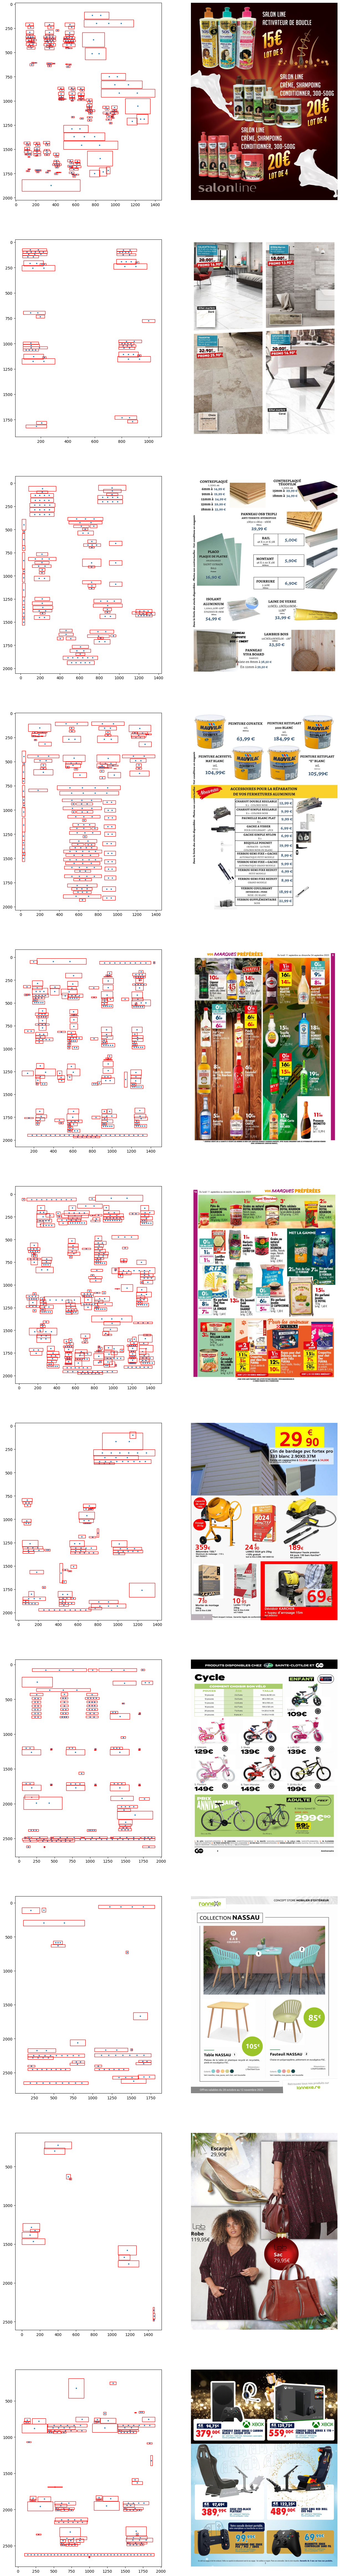

In [5]:
# TODO: Make 3 functions: plot_scatter_from_path(), plt_image_from_path(), plot_dbscan_result_from_path()
plt.figure(figsize=(15, 120))


i = 0
for image_path in list(dict_datas.keys()):
    i += 1
    x_values = [position[0] for position in dict_datas[image_path]]
    y_values = [position[1] for position in dict_datas[image_path]]

    plt.subplot(11, 2, i)
    plt.scatter(x_values, y_values, s=5)
    for elt in dict_datas[image_path]:
        if len(elt) > 2:
            x1 = elt[2]
            y1 = elt[3]
            width = elt[4]
            height = elt[5]

            box = Rectangle((x1, y1), width, height, edgecolor="red", facecolor="none")
            plt.gca().add_patch(box)
    plt.gca().invert_yaxis()

    i += 1
    plt.subplot(11, 2, i)
    img = mpimg.imread(image_path)
    plt.imshow(img, aspect="auto")
    plt.axis("off")


plt.show()

## 6. Test DBSCAN

In [6]:
# TODO: Dynamically find eps value 

dbscan = DBSCAN(eps=100, min_samples=3)

X = np.array([[position[0], position[1]] for position in dict_datas[paths[-1]]])

Number of clusters found: 13


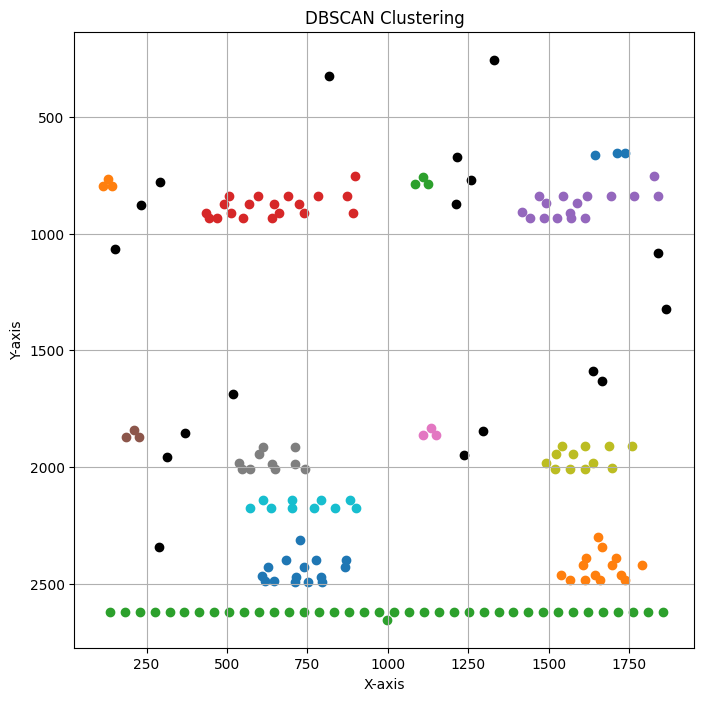

In [7]:
# # Fitting the DBSCAN model to the data
# dbscan.fit(X)

# # Getting cluster labels (-1 represents outliers or noise points)
# cluster_labels = dbscan.labels_

# # Getting the number of clusters (ignoring noise if labeled as -1)
# num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
# print(f"Number of clusters found: {num_clusters}")

# # Plotting the clustered data
# plt.figure(figsize=(8, 8))

# # Plotting points with different colors for different clusters
# for i in range(num_clusters):
#     cluster_points = X[cluster_labels == i]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

# # Plotting outliers or noise points as black
# outliers = X[cluster_labels == -1]
# plt.scatter(outliers[:, 0], outliers[:, 1], color='black', label='Outliers (Noise)')

# plt.title('DBSCAN Clustering')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# # ---
# plt.gca().invert_yaxis()
# # plt.legend()
# # ---

# plt.grid(True)
# plt.show()

# 7. Test Affinity Propagation

In [8]:
# af = AffinityPropagation(random_state=5).fit(X)
# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_

# n_clusters_ = len(cluster_centers_indices)

# print("Estimated number of clusters: %d" % n_clusters_)

Estimated number of clusters: 9


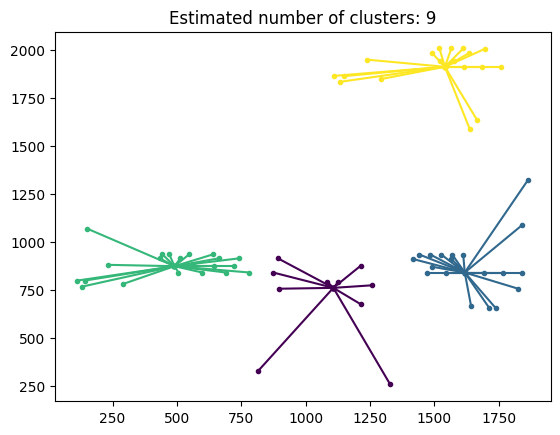

In [9]:
# plt.close("all")
# plt.figure(1)
# plt.clf()

# colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, 4)))

# for k, col in zip(range(n_clusters_), colors):
#     class_members = labels == k
#     cluster_center = X[cluster_centers_indices[k]]
#     plt.scatter(
#         X[class_members, 0], X[class_members, 1], color=col["color"], marker="."
#     )
#     plt.scatter(
#         cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o"
#     )
#     for x in X[class_members]:
#         plt.plot(
#             [cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"]
#         )

# plt.title("Estimated number of clusters: %d" % n_clusters_)
# plt.show()

# 8. Test Mean-Shift

In [10]:
# clustering = MeanShift().fit(X)
# labels = clustering.labels_
# cluster_centers = clustering.cluster_centers_

IndexError: index 2 is out of bounds for axis 0 with size 2

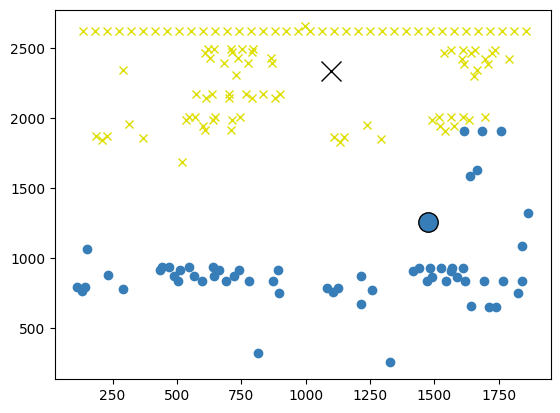

In [11]:
# plt.figure(1)
# plt.clf()

# colors = ["#dede00", "#377eb8", "#f781bf"]
# markers = ["x", "o", "^"]

# for k, col in zip(range(n_clusters_), colors):
#     my_members = labels == k
#     cluster_center = cluster_centers[k]
#     plt.plot(X[my_members, 0], X[my_members, 1], markers[k], color=col)
#     plt.plot(
#         cluster_center[0],
#         cluster_center[1],
#         markers[k],
#         markerfacecolor=col,
#         markeredgecolor="k",
#         markersize=14,
#     )
# plt.title("Estimated number of clusters: %d" % n_clusters_)
# plt.show()

# 9. Test Ward Hierarchical

In [30]:
from sklearn.cluster import AgglomerativeClustering


clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1000, compute_full_tree=True).fit(X)
clustering
print(clustering.labels_)
print(clustering.n_clusters_)

[ 2  2  1  1  1 10 10  3  2  2  2  2  1 10 10  3  3  3  3  3  1  1  1  1
  1  1 10  3  3  3  3  2  1  1  3  3  3  3  3  1  1  3  3  3  3  1  1  1
  1  1 10  8  8  8 11 11 11 11 12 12 12 12  5  5  6  6  6  6 11  5 12  6
  6  5  5  5  6  6  5  5  5  5  6  6  6  6  5  5  5  5  5  5  5  5  5  5
  0  4  4  0  0  0  4  4  0  0  0  4  4  4  0  0  0  4  4  4  0  0  0  0
  0  4  4  4  4  7  7  7  7  7  7  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  9  9  9  9  9  9  9  4  4  4  4  4  4  4  4  4  4  4  0  2  8 11  7]
13


DBSCAN et HDBSCAN => pas adaptée car pas de relle notion de "centre" de cluster

Essayer plutot Affinity Propagation !